In [1]:
import numpy as np
import sympy as sp
from sympy import Symbol
from sympy import solve, Poly, Eq, Function, exp
import math
import matplotlib.pyplot as plt
from numpy.lib.scimath import sqrt as csqrt
from scipy.signal import find_peaks
from scipy.constants import lambda2nu, nu2lambda, c
import os
import imp
import matplotlib.pyplot as plt
import sys
import scipy.io
import scipy.optimize
#windows path
#os.add_dll_directory('C:\\Program Files\\Lumerical\\v202\\api\\python\\') 
#lumapi = imp.load_source('lumapi','C:\\Program Files\\Lumerical\\v202\\api\\python\\lumapi.py')

#linux path
sys.path.append("/opt/lumerical/v221/api/python") #Default linux lumapi path
import lumapi
sys.path.append(os.path.dirname('/home/moises/Downloads/'))

## engine
#/opt/lumerical/v221/bin

In [2]:
font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : 16}

In [3]:
def fit_sin(tt, yy):
    '''Fit sin to the input time sequence, and return fitting parameters "amp", "omega", "phase", "offset", "freq", "period" and "fitfunc"'''
    tt = np.array(tt)
    yy = np.array(yy)
    ff = np.fft.fftfreq(len(tt), (tt[1]-tt[0]))   # assume uniform spacing
    Fyy = abs(np.fft.fft(yy))
    guess_freq = abs(ff[np.argmax(Fyy[1:])+1])   # excluding the zero frequency "peak", which is related to offset
    guess_amp = np.std(yy) * 2.**0.5
    guess_offset = np.mean(yy)
    guess = np.array([guess_amp, 2.*np.pi*guess_freq, 0., guess_offset])

    def sinfunc(t, A, w, p, c):  return A * np.sin(w*t + p) + c
    popt, pcov = scipy.optimize.curve_fit(sinfunc, tt, yy, p0=guess)
    A, w, p, c = popt
    f = w/(2.*np.pi)
    fitfunc = lambda t: A * np.sin(w*t + p) + c
    #return A
    return {"amp": A, "omega": w, "phase": p, "offset": c, "freq": f, "period": 1./f, "fitfunc": fitfunc, "maxcov": np.max(pcov), "rawres": (guess,popt,pcov)}

def linear(t,a,b):
    return a*t + b

In [36]:
inter = lumapi.INTERCONNECT(filename= 'hybrid_total.icp')

In [78]:
Result_IN = inter.getresult('OSC_1', 'signal')
Result_IP = inter.getresult('OSC_2', 'signal')
Result_QN = inter.getresult('OSC_3', 'signal')
Result_QP = inter.getresult('OSC_4', 'signal')
time = Result_IN['time']
IN_sampled = Result_IN['amplitude (a.u.)']
IP_sampled = Result_IP['amplitude (a.u.)']
QN_sampled = Result_QN['amplitude (a.u.)']
QP_sampled = Result_QP['amplitude (a.u.)']
t = np.ndarray.flatten(time)
IN = np.ndarray.flatten(IN_sampled)
IP = np.ndarray.flatten(IP_sampled)
QN = np.ndarray.flatten(QN_sampled)
QP = np.ndarray.flatten(QP_sampled)
c = 299792458

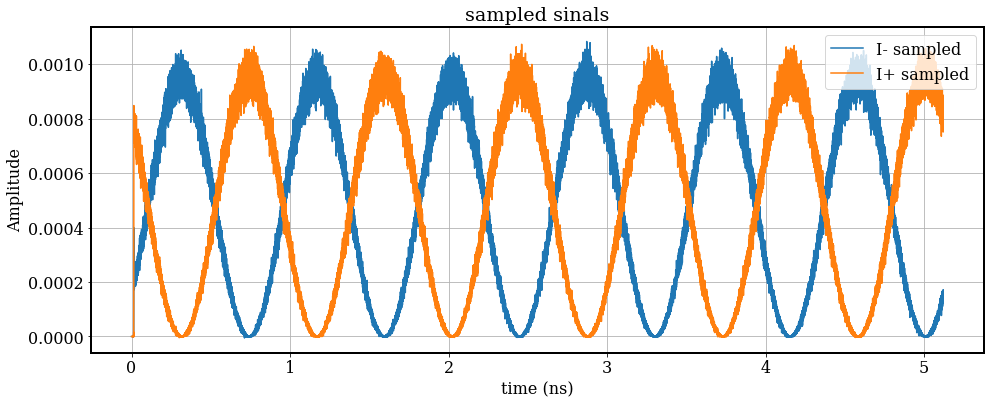

In [76]:
figure = plt.figure(figsize = (16, 6))
plt.rc('font', **font)
plt.rc('axes', linewidth=2)
plt.plot(time*1e9, IN_sampled, label = 'I- sampled')
plt.plot(time*1e9, IP_sampled, label = 'I+ sampled')
#plt.plot(time*1e9, QN_sampled, label = 'Q- sampled')
#plt.plot(time*1e9, QP_sampled, label = 'Q+ sampled')
plt.grid(True)
plt.xlabel('time (ns)')
plt.ylabel('Amplitude')
plt.title('sampled sinals')
plt.legend(loc = 'upper right')

In [88]:
fit_IN = fit_sin(t, IN)
fit_IP = fit_sin(t, IP)
fit_QN = fit_sin(t, QN)
fit_QP = fit_sin(t, QP)

In [90]:
(fit_IN['phase'] - fit_IP['phase'])

-0.051795739072937

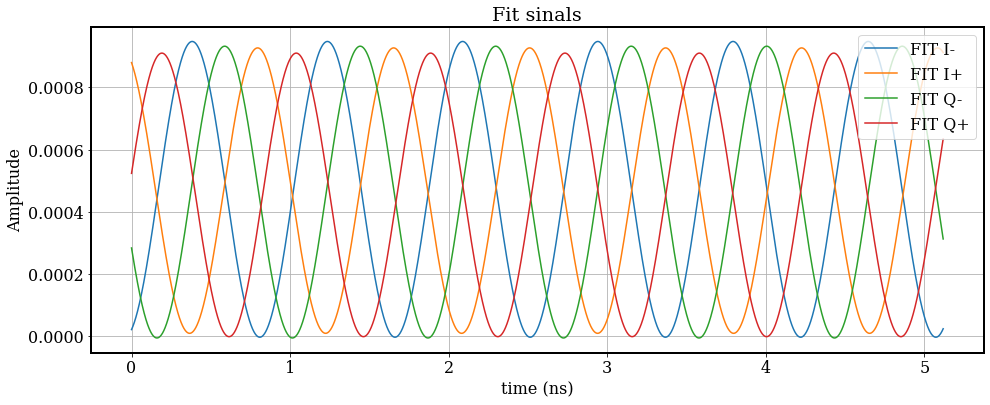

In [39]:
figure = plt.figure(figsize = (16, 6))
plt.rc('font', **font)
plt.rc('axes', linewidth=2)
plt.plot(time*1e9, fit_IN['amp']*np.sin(2*np.pi*fit_IN['freq']*t+fit_IN['phase'])+fit_IN['offset'], label = 'FIT I-')
plt.plot(time*1e9, fit_IP['amp']*np.sin(2*np.pi*fit_IP['freq']*t+fit_IP['phase'])+fit_IP['offset'], label = 'FIT I+')
plt.plot(time*1e9, fit_QN['amp']*np.sin(2*np.pi*fit_QN['freq']*t+fit_QN['phase'])+fit_QN['offset'], label = 'FIT Q-')
plt.plot(time*1e9, fit_QP['amp']*np.sin(2*np.pi*fit_QP['freq']*t+fit_QP['phase'])+fit_QP['offset'], label = 'FIT Q+')
plt.grid(True)
plt.xlabel('time (ns)')
plt.ylabel('Amplitude')
plt.title('Fit sinals')
plt.legend(loc = 'upper right')

In [113]:
freq = np.arange(1530e-9, 1565e-9, 1e-9)
diff = 0.01e-9
phase_QP = np.zeros(len(freq))
phase_QN = np.zeros(len(freq))
phase_IP = np.zeros(len(freq))
phase_IN = np.zeros(len(freq))

for i in range(len(freq)):
    inter.switchtodesign()
    inter.setnamed('CWL_1', 'frequency', c/freq[i])
    inter.setnamed('CWL_2', 'frequency', c/(freq[i] + diff))
    inter.run()

    Result_IN = inter.getresult('OSC_1', 'signal')
    Result_IP = inter.getresult('OSC_2', 'signal')
    Result_QN = inter.getresult('OSC_3', 'signal')
    Result_QP = inter.getresult('OSC_4', 'signal')
    IN_sampled = Result_IN['amplitude (a.u.)']
    IP_sampled = Result_IP['amplitude (a.u.)']
    QN_sampled = Result_QN['amplitude (a.u.)']
    QP_sampled = Result_QP['amplitude (a.u.)']
    IN = np.ndarray.flatten(IN_sampled)
    IP = np.ndarray.flatten(IP_sampled)
    QN = np.ndarray.flatten(QN_sampled)
    QP = np.ndarray.flatten(QP_sampled)
    time = Result_IN['time']
    t = np.ndarray.flatten(time)
    
    fit_IN = fit_sin(t, IN)
    fit_IP = fit_sin(t, IP)
    fit_QN = fit_sin(t, QN)
    fit_QP = fit_sin(t, QP)

    phase_IN[i] = fit_IN['phase']
    phase_IP[i] = fit_IP['phase']
    phase_QN[i] = fit_QN['phase']
    phase_QP[i] = fit_QP['phase']    

Text(0, 0.5, 'phase error (degree)')

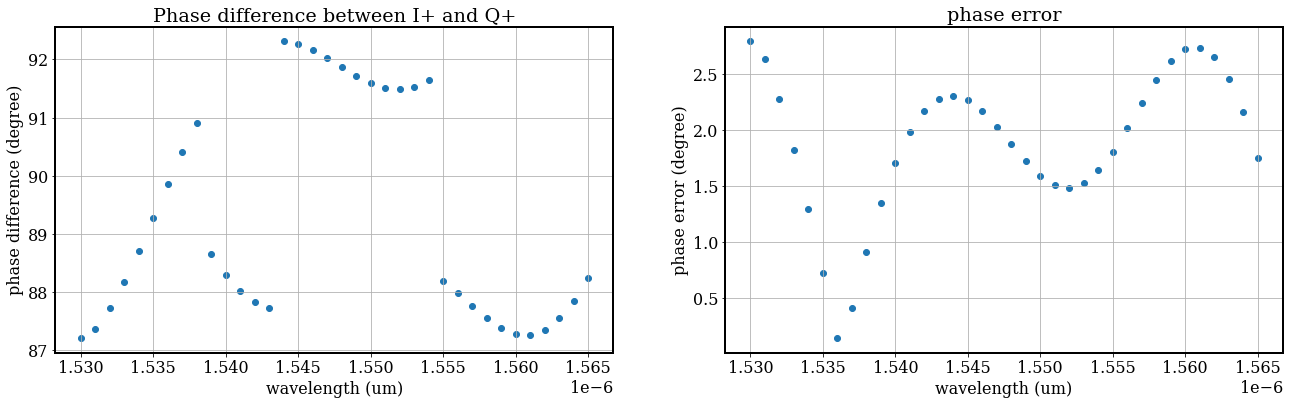

In [138]:
fig, ax = plt.subplots(1, 2, figsize = (22, 6))
plt.rc('font', **font)
plt.rc('axes', linewidth=2)
ax[0].scatter(freq, abs(phase_QP - phase_IP)*180/np.pi)
ax[0].grid(True)
ax[0].set_title('Phase difference between I+ and Q+')
ax[0].set_xlabel('wavelength (um)')
ax[0].set_ylabel('phase difference (degree)')

ax[1].scatter(freq, abs(90 - abs(phase_QP - phase_IP)*180/np.pi))
ax[1].grid(True)
ax[1].set_title('phase error')
ax[1].set_xlabel('wavelength (um)')
ax[1].set_ylabel('phase error (degree)')

Text(0, 0.5, 'phase error (degree)')

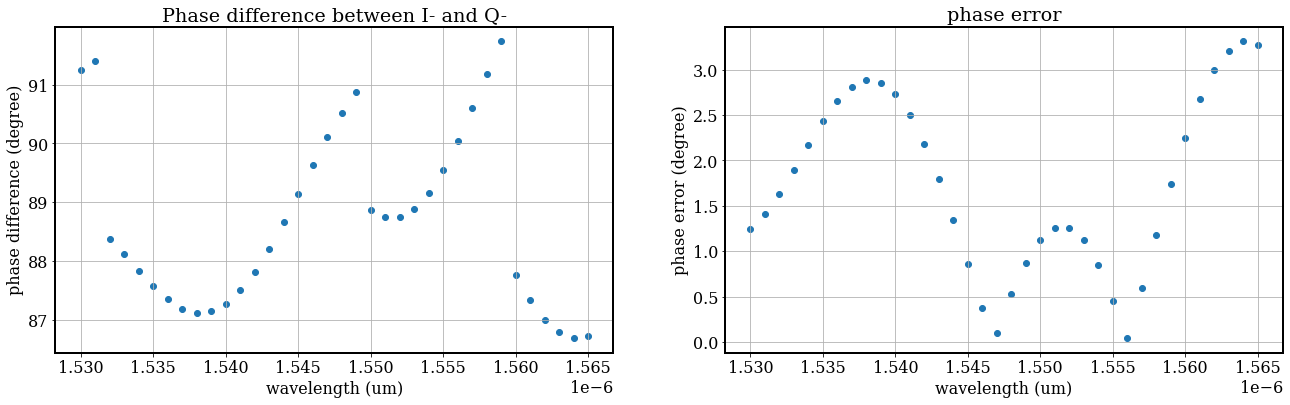

In [139]:
fig, ax = plt.subplots(1, 2, figsize = (22, 6))
plt.rc('font', **font)
plt.rc('axes', linewidth=2)
ax[0].scatter(freq, abs(phase_QN - phase_IN)*180/np.pi)
ax[0].grid(True)
ax[0].set_title('Phase difference between I- and Q-')
ax[0].set_xlabel('wavelength (um)')
ax[0].set_ylabel('phase difference (degree)')

ax[1].scatter(freq, abs(90 - abs(phase_QN - phase_IN)*180/np.pi))
ax[1].grid(True)
ax[1].set_title('phase error')
ax[1].set_xlabel('wavelength (um)')
ax[1].set_ylabel('phase error (degree)')